In [1]:
# Встановлюємо необхідні бібліотеки
!pip install ultralytics torchinfo pandas roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.9 MB/s eta 0:00:00


In [21]:
# Імпортуємо пакети
import torch
import os
import yaml
import pandas as pd
import numpy as np
import time
from ultralytics import YOLO
from torchinfo import summary
from google.colab import files
from roboflow import Roboflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Перевірка GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")
if device.type == 'cpu':
    print("GPU не знайдено!")

Використовується пристрій: cuda


In [5]:
RF_API_KEY = "cPFHreBTk8PuDYeI6HyZ"

rf = Roboflow(api_key=RF_API_KEY)

# 1. Завантажуємо ДЕННИЙ набір
print("Завантаження Денного набору")
project_day = rf.workspace("bohdana").project("bdd100k_daytime-u8j82-c4nyg")
version_day = project_day.version(1)
dataset_day = version_day.download("yolov8")
DAY_DATA_PATH = dataset_day.location
print(f"Денні дані: {DAY_DATA_PATH}")

# 2. Завантажуємо НІЧНИЙ набір
print("\nЗавантаження Нічного набору")
project_night = rf.workspace("bohdana").project("bdd100k-finetune-e2bk1")
version_night = project_night.version(1)
dataset_night = version_night.download("yolov8")
NIGHT_DATA_PATH = dataset_night.location
print(f"Нічні дані: {NIGHT_DATA_PATH}")

Завантаження Денного набору
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bdd100k_daytime-1 in yolov8:: 100%|██████████| 2612/2612 [00:00<00:00, 5459.85it/s]

Денні дані: /content/bdd100k_daytime-1

Завантаження Нічного набору
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to bdd100k-finetune-1 in yolov8:: 100%|██████████| 63810/63810 [00:12<00:00, 5094.07it/s]


Нічні дані: /content/bdd100k-finetune-1


In [6]:
# 3. Створення конфігураційного файлу .yaml для Domain Shift
print("\nСтворення bdd_domain_shift.yaml")

# Отримуємо класи з денного набору
with open(f'{DAY_DATA_PATH}/data.yaml', 'r') as f:
    day_yaml = yaml.safe_load(f)
    class_names = day_yaml['names']
    num_classes = day_yaml['nc']

# Конфіг: Тренування на дні, Тест на ночі
domain_shift_config = {
    'train': f'{DAY_DATA_PATH}/train/images',
    'val': f'{DAY_DATA_PATH}/valid/images',
    'test': f'{NIGHT_DATA_PATH}/test/images', # Тестуємо на нічних!
    'nc': num_classes,
    'names': class_names
}

with open('bdd_domain_shift.yaml', 'w') as f:
    yaml.dump(domain_shift_config, f)

print("Файл конфігурації створено.")


Створення bdd_domain_shift.yaml
Файл конфігурації створено.


In [7]:
# Функція для читання yaml файлу
def get_classes_from_yaml(path):
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
        return data['names'], data['nc']

# Отримуємо інформацію з обох наборів
try:
    day_names, day_nc = get_classes_from_yaml(f'{DAY_DATA_PATH}/data.yaml')
    night_names, night_nc = get_classes_from_yaml(f'{NIGHT_DATA_PATH}/data.yaml')

    print(f"Денний набір: {day_nc} класів -> {day_names}")
    print(f"Нічний набір: {night_nc} класів -> {night_names}")

    # Використовуємо класи з НІЧНОГО набору, якщо там їх більше, щоб уникнути помилки "index out of range".

    target_names = night_names
    target_nc = night_nc

    print(f"\nВикористовуємо конфігурацію: {target_nc} класів.")

    # Створюємо наш конфіг для Domain Shift
    domain_shift_config = {
        'train': f'{DAY_DATA_PATH}/train/images',
        'val': f'{DAY_DATA_PATH}/valid/images',
        'test': f'{NIGHT_DATA_PATH}/test/images',

        'nc': target_nc,
        'names': target_names
    }

    with open('bdd_domain_shift.yaml', 'w') as f:
        yaml.dump(domain_shift_config, f)

    print("Файл bdd_domain_shift.yaml успішно перезаписано!")

except Exception as e:
    print(f"Помилка при читанні YAML: {e}")

Денний набір: 7 класів -> ['bus', 'car', 'person', 'rider', 'traffic light', 'traffic sign', 'truck']
Нічний набір: 22 класів -> ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'bike', 'bus', 'car', 'motor', 'person', 'rider', 'tl_green', 'tl_none', 'tl_red', 'tl_yellow', 'train', 'truck']

Використовуємо конфігурацію: 22 класів.
Файл bdd_domain_shift.yaml успішно перезаписано!


In [8]:
!rm {NIGHT_DATA_PATH}/test/labels.cache
!rm {DAY_DATA_PATH}/train/labels.cache
!rm {DAY_DATA_PATH}/valid/labels.cache

rm: cannot remove '/content/bdd100k-finetune-1/test/labels.cache': No such file or directory
rm: cannot remove '/content/bdd100k_daytime-1/train/labels.cache': No such file or directory
rm: cannot remove '/content/bdd100k_daytime-1/valid/labels.cache': No such file or directory


In [9]:
# YOLOv8n (Nano)
# Навчання (Train on Day)
print("Початок навчання YOLOv8n")
!yolo task=detect mode=train \
    model=yolov8n.pt \
    data=bdd_domain_shift.yaml \
    epochs=20 \
    imgsz=640 \
    project='BDD_DomainShift_Lab' \
    name='yolov8n_day_train' \
    seed=42 \
    exist_ok=True \
    verbose=False

Початок навчання YOLOv8n
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bdd_domain_shift.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_day_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [11]:
# YOLOv8s (Small)
# Навчання (Train on Day)
print("Початок навчання YOLOv8s")
!yolo task=detect mode=train \
    model=yolov8s.pt \
    data=bdd_domain_shift.yaml \
    epochs=20 \
    imgsz=640 \
    project='BDD_DomainShift_Lab' \
    name='yolov8s_day_train' \
    seed=42 \
    exist_ok=True \
    verbose=False

Початок навчання YOLOv8s
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bdd_domain_shift.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_day_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

In [13]:
# Оцінка YOLOv8n (Night)
print("Оцінка YOLOv8n на нічних даних")
!yolo task=detect mode=val \
    model='BDD_DomainShift_Lab/yolov8n_day_train/weights/best.pt' \
    data='bdd_domain_shift.yaml' \
    split=test \
    project='BDD_DomainShift_Lab' \
    name='yolov8n_night_test' \
    exist_ok=True

# Оцінка YOLOv8s (Night)
print("\nОцінка YOLOv8s на нічних даних")
!yolo task=detect mode=val \
    model='BDD_DomainShift_Lab/yolov8s_day_train/weights/best.pt' \
    data='bdd_domain_shift.yaml' \
    split=test \
    project='BDD_DomainShift_Lab' \
    name='yolov8s_night_test' \
    exist_ok=True

Оцінка YOLOv8n на нічних даних
Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,938 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.5±12.1 MB/s, size: 48.8 KB)
val: Scanning /content/bdd100k-finetune-1/test/labels... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 700.7it/s 0.1s
val: New cache created: /content/bdd100k-finetune-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.0it/s 2.0s
                   all         60        881          0          0          0          0
                  bike          3          4          0          0          0          0
                   bus          4          4          0          0          0          0
                   car         60        620          0          0          0          0
                person          9        

In [14]:
# Аналіз та порівняльна таблиця

import glob

# Функція для пошуку файлу результатів
def get_metrics_from_folder(folder_pattern):
    # Шукаємо папку
    found_folders = glob.glob(folder_pattern)
    if not found_folders:
        print(f"Папку не знайдено: {folder_pattern}")
        return 0.0, 0.0

    folder = found_folders[0] # Беремо першу знайдену
    csv_path = os.path.join(folder, 'results.csv')

    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path)
            df.columns = df.columns.str.strip()
            # Беремо останній рядок
            map50 = df.iloc[-1].get('metrics/mAP50(B)', 0.0)
            map5095 = df.iloc[-1].get('metrics/mAP50-95(B)', 0.0)
            return map50, map5095
        except Exception as e:
            print(f"Помилка читання CSV у {folder}: {e}")
            return 0.0, 0.0
    else:
        print(f"Файл results.csv відсутній у {folder}")
        # Якщо файлу немає, але папка є, і ми бачили в логах нулі -> повертаємо 0
        return 0.0, 0.0

# Отримуємо метрики (автоматично або 0)
print("Зчитування метрик...")
# Шукаємо папки, навіть якщо YOLO додав цифру (напр. night_test2)
map50_n, map5095_n = get_metrics_from_folder('BDD_DomainShift_Lab/yolov8n_night_test*')
map50_s, map5095_s = get_metrics_from_folder('BDD_DomainShift_Lab/yolov8s_night_test*')

print(f"YOLOv8n Night mAP: {map50_n}")
print(f"YOLOv8s Night mAP: {map50_s}")


# Функція FPS
def measure_fps(model_path, device_name="cuda"):
    try:
        model = YOLO(model_path)
        dev = torch.device(device_name)
        dummy_input = np.random.rand(640, 640, 3).astype(np.float32)
        # Прогрів
        for _ in range(5): model.predict(source=dummy_input, device=dev, verbose=False)
        # Тест
        times = []
        for _ in range(20): # Менше ітерацій для швидкості
            if device_name == "cuda": torch.cuda.synchronize()
            start = time.time()
            model.predict(source=dummy_input, device=dev, verbose=False)
            if device_name == "cuda": torch.cuda.synchronize()
            times.append(time.time() - start)
        return 1.0 / np.mean(times)
    except: return 0.0

# Збір технічних даних та формування таблиці
# Шляхи до ваг
path_n = 'BDD_DomainShift_Lab/yolov8n_day_train/weights/best.pt'
path_s = 'BDD_DomainShift_Lab/yolov8s_day_train/weights/best.pt'

try:
    # v8n
    if os.path.exists(path_n):
        model_n = YOLO(path_n)
        info_n = summary(model_n.model, input_size=(1, 3, 640, 640), verbose=0)
        params_n = info_n.total_params / 1e6
        flops_n = info_n.total_mult_adds / 1e9
        size_n = os.path.getsize(path_n) / (1024**2)
        fps_n_gpu = measure_fps(path_n, "cuda")
        fps_n_cpu = measure_fps(path_n, "cpu")
    else:
        print("Ваги v8n не знайдено")
        params_n, flops_n, size_n, fps_n_gpu, fps_n_cpu = 0,0,0,0,0

    # v8s
    if os.path.exists(path_s):
        model_s = YOLO(path_s)
        info_s = summary(model_s.model, input_size=(1, 3, 640, 640), verbose=0)
        params_s = info_s.total_params / 1e6
        flops_s = info_s.total_mult_adds / 1e9
        size_s = os.path.getsize(path_s) / (1024**2)
        fps_s_gpu = measure_fps(path_s, "cuda")
        fps_s_cpu = measure_fps(path_s, "cpu")
    else:
        print("Ваги v8s не знайдено")
        params_s, flops_s, size_s, fps_s_gpu, fps_s_cpu = 0,0,0,0,0

    # Таблиця
    data = {
        'imgsz': [640, 640],
        'Параметри (M)': [params_n, params_s],
        'FLOPs (G)': [flops_n, flops_s],
        'mAP@0.5 (Night)': [map50_n, map50_s],
        'mAP@0.5:0.95 (Night)': [map5095_n, map5095_s],
        'FPS (GPU)': [fps_n_gpu, fps_s_gpu],
        'FPS (CPU)': [fps_n_cpu, fps_s_cpu],
        'Розмір ваг (MB)': [size_n, size_s]
    }
    df = pd.DataFrame(data, index=['YOLOv8n', 'YOLOv8s'])
    df.index.name = "Модель"

    print("\nФінальна таблиця (Domain Shift: Day -> Night)")
    pd.options.display.float_format = '{:,.3f}'.format
    display(df)

    df.to_csv('yolo_comparison.csv')
    print("\nТаблицю збережено у файл 'yolo_comparison.csv'")

except Exception as e:
    print(f"Критична помилка: {e}")

Зчитування метрик...
Файл results.csv відсутній у BDD_DomainShift_Lab/yolov8n_night_test
Файл results.csv відсутній у BDD_DomainShift_Lab/yolov8s_night_test
YOLOv8n Night mAP: 0.0
YOLOv8s Night mAP: 0.0

Фінальна таблиця (Domain Shift: Day -> Night)


,imgsz,Параметри (M),FLOPs (G),mAP@0.5 (Night),mAP@0.5:0.95 (Night),FPS (GPU),FPS (CPU),Розмір ваг (MB)
Модель,,,,,,,,
YOLOv8n,640,5.064,4.053,0.000,0.000,88.086,6.293,5.941
YOLOv8s,640,18.951,14.240,0.000,0.000,67.296,2.039,21.464



Таблицю збережено у файл 'yolo_comparison.csv'



Криві навчання


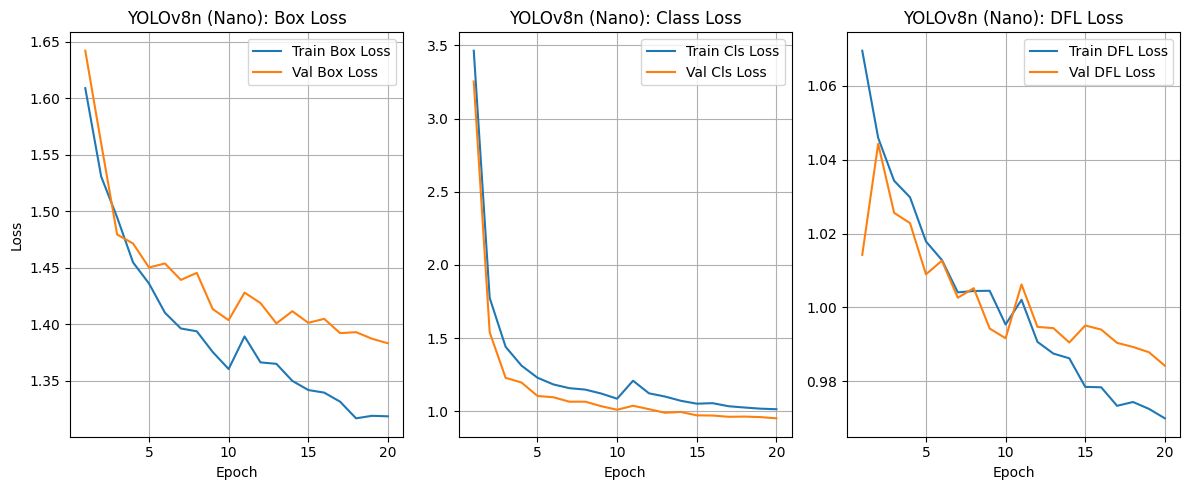

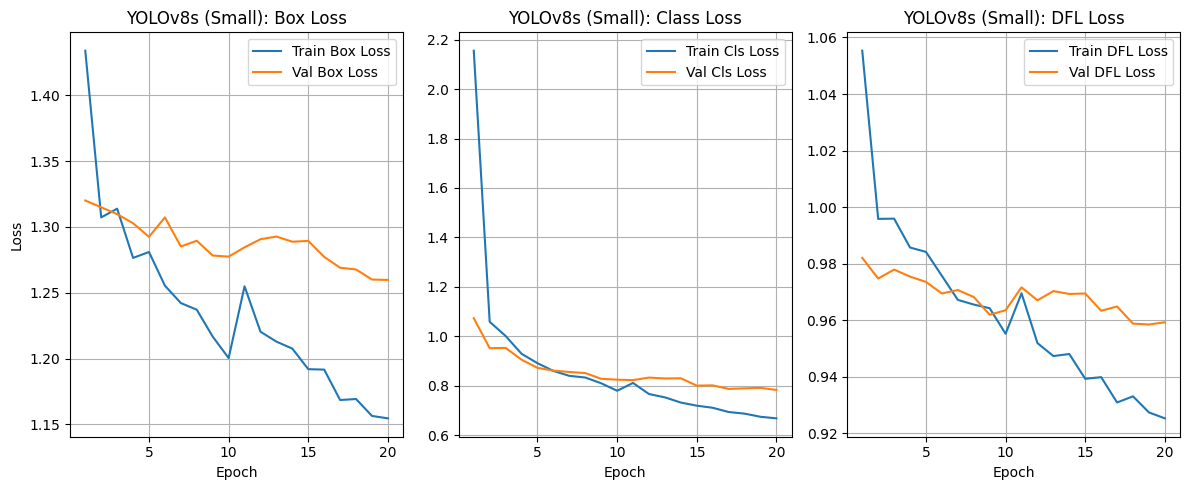

In [19]:
# Функція для побудови графіків навчання
def plot_yolo_loss(results_path, model_name):
    if not os.path.exists(results_path):
        print(f"Файл результатів не знайдено: {results_path}")
        return

    # Зчитуємо CSV
    df = pd.read_csv(results_path)
    # Очищуємо назви колонок від пробілів
    df.columns = df.columns.str.strip()

    # Створюємо графік
    plt.figure(figsize=(12, 5))

    # Графік Box Loss (точність рамок)
    plt.subplot(1, 3, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    plt.title(f'{model_name}: Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Графік Class Loss (точність класифікації)
    plt.subplot(1, 3, 2)
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
    plt.title(f'{model_name}: Class Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Графік DFL Loss (Distribution Focal Loss)
    plt.subplot(1, 3, 3)
    plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
    plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
    plt.title(f'{model_name}: DFL Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Виклик функції для обох моделей
print("\nКриві навчання")

# Шляхи до файлів results.csv
path_results_v8n = 'BDD_DomainShift_Lab/yolov8n_day_train/results.csv'
path_results_v8s = 'BDD_DomainShift_Lab/yolov8s_day_train/results.csv'

# Будуємо графіки
plot_yolo_loss(path_results_v8n, 'YOLOv8n (Nano)')
plot_yolo_loss(path_results_v8s, 'YOLOv8s (Small)')

Saving day_1.jpg to day_1.jpg
Saving day_2.jpg to day_2.jpg
Saving night_1.jpeg to night_1.jpeg
Saving night_2.jpg to night_2.jpg
Завантажено: ['day_1.jpg', 'day_2.jpg', 'night_1.jpeg', 'night_2.jpg']

Прогноз YOLOv8n

0: 640x640 7 10s, 4 5s, 1 6, 5.5ms
1: 640x640 14 10s, 8 5s, 2 6s, 5.5ms
2: 640x640 5 10s, 5.5ms
3: 640x640 4 10s, 1 5, 1 6, 5.5ms
Speed: 3.0ms preprocess, 5.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/BDD_DomainShift_Lab/infer_v8n
YOLOv8n: Успішно!

Прогноз YOLOv8s

0: 640x640 6 10s, 6 5s, 1 6, 13.4ms
1: 640x640 9 10s, 8 5s, 2 6s, 13.4ms
2: 640x640 3 10s, 13.4ms
3: 640x640 1 1, 5 10s, 2 5s, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/BDD_DomainShift_Lab/infer_v8s
YOLOv8s: Успішно!


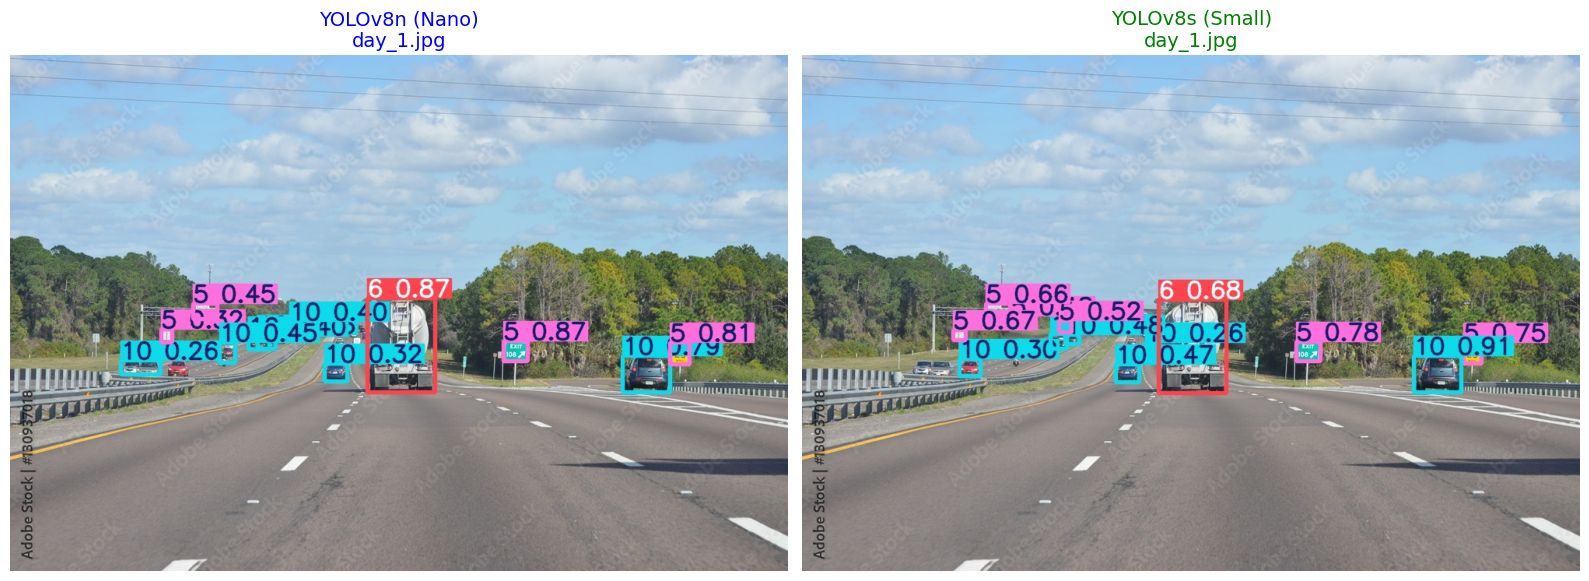

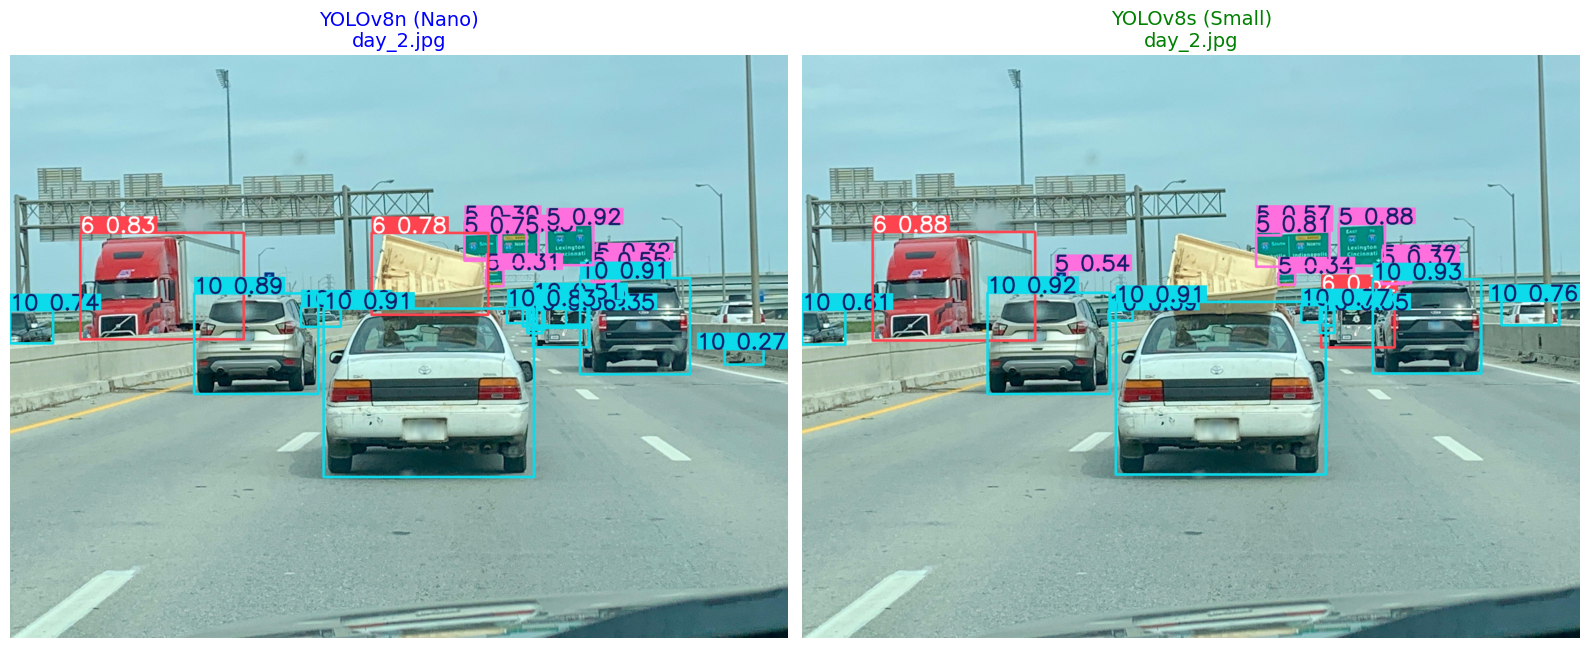

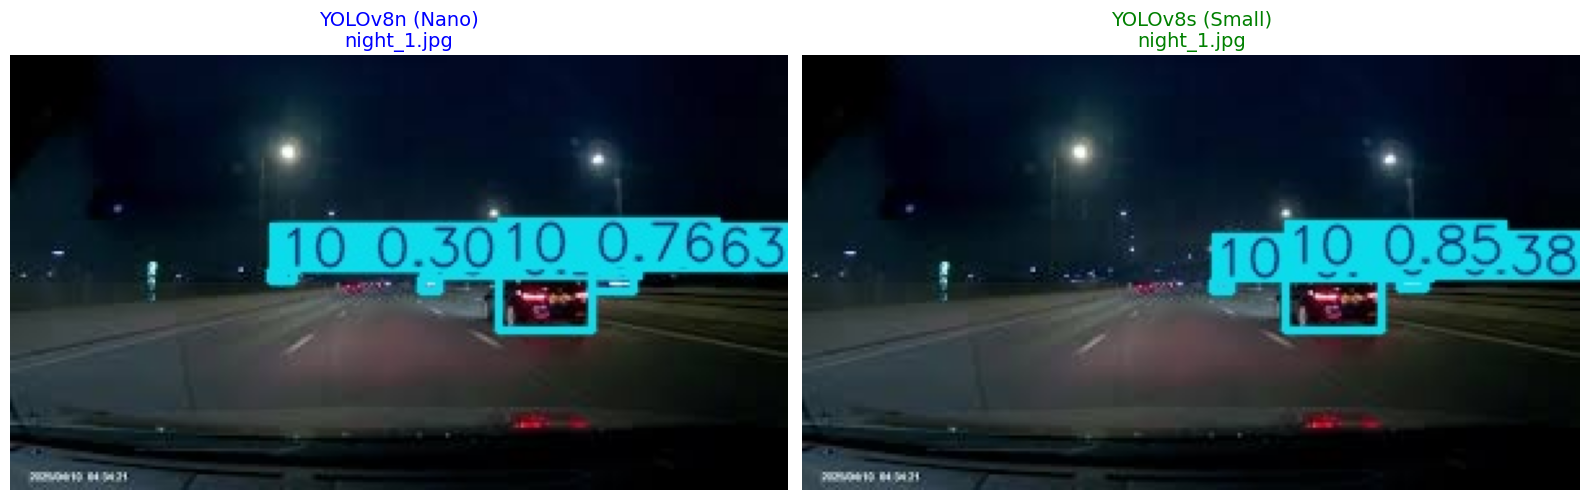

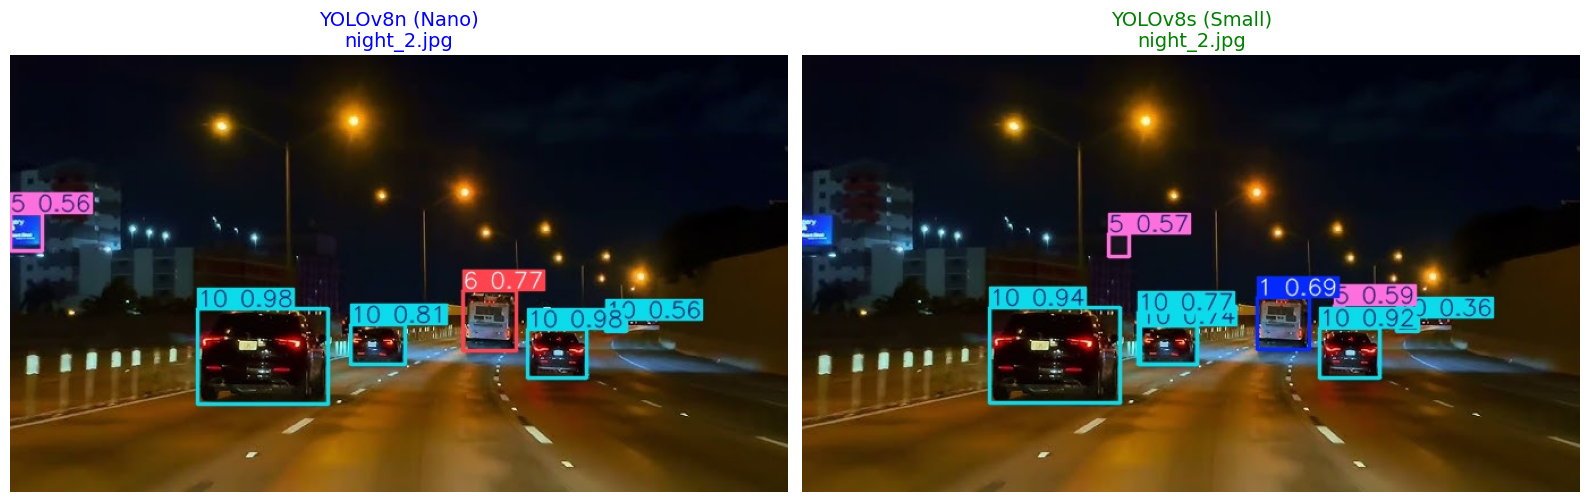

In [24]:
# Інтерфейс на власних файлах

uploaded = files.upload()
file_names = list(uploaded.keys())

if file_names:
    print(f"Завантажено: {file_names}")

    # Шляхи до моделей
    path_n = 'BDD_DomainShift_Lab/yolov8n_day_train/weights/best.pt'
    path_s = 'BDD_DomainShift_Lab/yolov8s_day_train/weights/best.pt'

    # Інференс YOLOv8n
    print("\nПрогноз YOLOv8n")
    try:
        model_n = YOLO(path_n)
        model_n.predict(
            source=file_names,
            save=True,
            conf=0.25,
            project='BDD_DomainShift_Lab',
            name='infer_v8n',
            exist_ok=True
        )
        print("YOLOv8n: Успішно!")
    except Exception as e:
        print(f"Помилка v8n: {e}")

    # Інференс YOLOv8s
    print("\nПрогноз YOLOv8s")
    try:
        model_s = YOLO(path_s)
        model_s.predict(
            source=file_names,
            save=True,
            conf=0.25,
            project='BDD_DomainShift_Lab',
            name='infer_v8s',
            exist_ok=True
        )
        print("YOLOv8s: Успішно!")
    except Exception as e:
        print(f"Помилка v8s: {e}")

# Функція для пошуку файлу, враховуючи зміну .jpeg -> .jpg
def get_result_path(folder, filename):
    # Шукаємо точне співпадіння
    path = os.path.join(folder, filename)
    if os.path.exists(path):
        return path

    # Якщо не знайшли, пробуємо замінити .jpeg на .jpg
    if filename.endswith('.jpeg'):
        new_filename = filename.replace('.jpeg', '.jpg')
        path = os.path.join(folder, new_filename)
        if os.path.exists(path):
            return path

    # Пробуємо просто .jpg
    base_name = os.path.splitext(filename)[0]
    path = os.path.join(folder, base_name + '.jpg')
    if os.path.exists(path):
        return path

    return None

for img_file in file_names:
    # Використовуємо розумний пошук шляху
    path_res_n = get_result_path('BDD_DomainShift_Lab/infer_v8n', img_file)
    path_res_s = get_result_path('BDD_DomainShift_Lab/infer_v8s', img_file)

    if path_res_n and path_res_s:
        # Створюємо фігуру
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Зображення YOLOv8n
        img_n = mpimg.imread(path_res_n)
        axes[0].imshow(img_n)
        axes[0].set_title(f"YOLOv8n (Nano)\n{os.path.basename(path_res_n)}", fontsize=14, color='blue')
        axes[0].axis('off')

        # Зображення YOLOv8s
        img_s = mpimg.imread(path_res_s)
        axes[1].imshow(img_s)
        axes[1].set_title(f"YOLOv8s (Small)\n{os.path.basename(path_res_s)}", fontsize=14, color='green')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Не вдалося знайти оброблені файли для {img_file}")